# Process total sci-ATAC-seq counts for all F1s

In [1]:
EXPERIMENT_IDS = 'f1'
TIMEPOINTS = 'all'

In [2]:
OUT_DIR = '_'.join([EXPERIMENT_IDS, TIMEPOINTS, 'windows'])

## Imports

In [3]:
import sys
import os

In [4]:
import numpy as np
import pandas as pd
import scanpy as sc
sc.settings.verbosity = 3

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
sys.path.append('..')
from utils import settings
from utils import dataloader
from utils import scanpy_sugar

## Load data

In [7]:
adata = dataloader.load_total_count_data(EXPERIMENT_IDS, TIMEPOINTS)

Checking if file exists: /icgc/dkfzlsdf/analysis/B260/users/heinent/projects/scdali_analyses/data/.cache/SS148.cusanovich_dm6_peaks.nowasp.counts_total.h5ad ... found.
 -> loading cached anndata ...
Checking if file exists: /icgc/dkfzlsdf/analysis/B260/users/heinent/projects/scdali_analyses/data/.cache/SS157.cusanovich_dm6_peaks.nowasp.counts_total.h5ad ... found.
 -> loading cached anndata ...
Checking if file exists: /icgc/dkfzlsdf/analysis/B260/users/heinent/projects/scdali_analyses/data/.cache/SS158.cusanovich_dm6_peaks.nowasp.counts_total.h5ad ... found.
 -> loading cached anndata ...
Checking if file exists: /icgc/dkfzlsdf/analysis/B260/users/heinent/projects/scdali_analyses/data/.cache/SS159.cusanovich_dm6_peaks.nowasp.counts_total.h5ad ... found.
 -> loading cached anndata ...


/icgc/dkfzlsdf/analysis/B260/users/heinent/envs/f1_analysis/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [8]:
adata

AnnData object with n_obs × n_vars = 40348 × 53133
    obs: 'timepoint', 'exp_id'
    var: 'chr', 'start', 'end', 'length'

## Basic filtering

Remove sex chromosomes.

In [9]:
n_peaks = adata.shape[1]
scanpy_sugar.filter_chromosomes(adata, chrs=['chrX', 'chrY'])
print(str(n_peaks - adata.shape[1]) + ' peaks filtered out.')

8968 peaks filtered out.


In [10]:
sc.pp.filter_cells(adata, min_genes=50)
sc.pp.filter_genes(adata, min_cells=50)

filtered out 24 cells that have less than 50 genes expressed
filtered out 57 genes that are detected in less than 50 cells


Compute basic qc stats.

In [11]:
sc.pp.calculate_qc_metrics(adata, inplace=True)

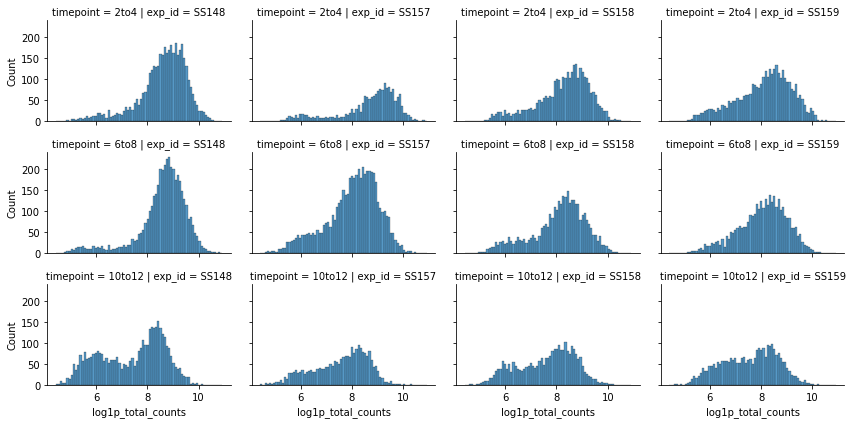

In [12]:
sns.displot(x='log1p_total_counts', data=adata.obs, col='exp_id', row='timepoint', height=2, aspect=1.5)

Save full count matrix in .raw.

In [13]:
adata.raw = adata

## Filter cells by timepoint for each cross 

In [14]:
adata

AnnData object with n_obs × n_vars = 40324 × 44108
    obs: 'timepoint', 'exp_id', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'chr', 'start', 'end', 'length', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

Filter < 10% quantile and > 99% quantile for each timepoint & exp id.

In [15]:
to_keep = pd.Series(data=False, name='keep', index=adata.obs_names)

for exp_id in adata.obs['exp_id'].unique():
    print('Filtering %s ...' % exp_id)
    for timepoint in adata.obs['timepoint'].unique():
        sub_obs = adata.obs[(adata.obs['exp_id'] == exp_id) & (adata.obs['timepoint'] == timepoint)]
        
        lower_bound = np.quantile(sub_obs['total_counts'], .1)
        upper_bound = np.quantile(sub_obs['total_counts'], .99)
        
        ids = sub_obs['total_counts'][(sub_obs['total_counts'] > lower_bound) & (sub_obs['total_counts'] < upper_bound)].index
        to_keep[ids] = True
        print(' %6s - bounds: [%d, %d], filtered: %.3d cells. Remaining: %d' % 
              (timepoint, lower_bound, upper_bound, sub_obs.shape[0] - len(ids), len(ids)))

Filtering SS148 ...
 10to12 - bounds: [264, 14124], filtered: 432 cells. Remaining: 3483
   6to8 - bounds: [1781, 25546], filtered: 466 cells. Remaining: 3761
   2to4 - bounds: [1506, 27999], filtered: 453 cells. Remaining: 3653
Filtering SS157 ...
 10to12 - bounds: [379, 12600], filtered: 255 cells. Remaining: 2053
   6to8 - bounds: [639, 18744], filtered: 578 cells. Remaining: 4666
   2to4 - bounds: [711, 29909], filtered: 201 cells. Remaining: 1616
Filtering SS158 ...
 10to12 - bounds: [382, 15384], filtered: 294 cells. Remaining: 2370
   6to8 - bounds: [637, 20936], filtered: 367 cells. Remaining: 2956
   2to4 - bounds: [834, 22099], filtered: 348 cells. Remaining: 2806
Filtering SS159 ...
 10to12 - bounds: [417, 15002], filtered: 303 cells. Remaining: 2438
   6to8 - bounds: [855, 19805], filtered: 369 cells. Remaining: 2969
   2to4 - bounds: [674, 23230], filtered: 384 cells. Remaining: 3103


In [16]:
n_cells = adata.shape[0]
adata = adata[to_keep, :]
print(str(n_cells - adata.shape[0]) + ' cells filtered out.')

/icgc/dkfzlsdf/analysis/B260/users/heinent/envs/f1_analysis/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


4450 cells filtered out.


Finally, apply hard threshold for number of peaks per cell and number of cells per peak.

In [17]:
sc.pp.filter_cells(adata, max_counts=20000)

filtered out 389 cells that have more than 20000 counts


Trying to set attribute `.obs` of view, copying.


In [18]:
ids = adata.var['n_cells_by_counts'].sort_values(ascending=False).index[:25000]

# to ensure consistency with the paper, we replace the following ties chosen in an earlier version of the software (all of them have n_cells_by_counts=1763)
exclude = ['chr2L_7200790_7201032', 'chr3R_8027105_8027266']
include = ['chr3L_22153944_22154095', 'chr3L_22733747_22733968']
# print(adata[:, ids].var['n_cells_by_counts'].min())
# print(adata[:, exclude + include].var['n_cells_by_counts'].min())
ids = ids.drop(exclude).append(pd.Index(include))
adata = adata[:, ids]

In [19]:
adata

View of AnnData object with n_obs × n_vars = 35485 × 25000
    obs: 'timepoint', 'exp_id', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_counts'
    var: 'chr', 'start', 'end', 'length', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

## LSI embedding

Perform LSI (tf-idf + approximate PCA) to get an initial impression of the data.


Note that we need to set zero_center=False so scanpy will call sklearn's TruncatedSVD.

In [20]:
scanpy_sugar.binarize(adata)

In [21]:
scanpy_sugar.calculate_tfidf(adata)
sc.tl.pca(adata, n_comps=20, zero_center=False)

computing PCA
    with n_comps=20
    finished (0:00:57)


Compute correlation with total cell counts and display summary plot.

In [22]:
scanpy_sugar.compute_obsm_count_corr(adata, key='X_pca')

In [23]:
lsi_stats = pd.DataFrame({
    'variance_ratio': adata.uns['pca']['variance_ratio'],
    'corr': adata.uns['pca']['corr_total_counts']}).iloc[:15, :]
lsi_stats['component'] = ['LSI' + str(i+1) for i in range(15)]

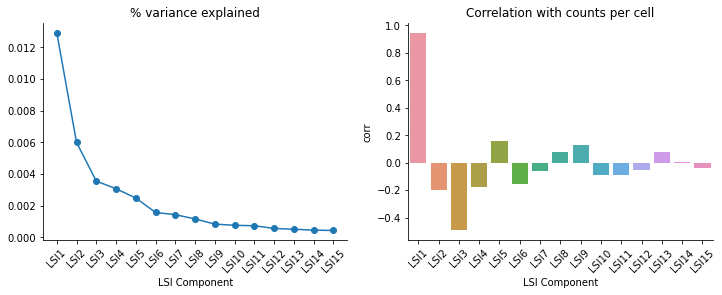

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
ax = axes[0]
ax.plot('component', 'variance_ratio', data=lsi_stats, linestyle='-', marker='o')
ax.set(xlabel='LSI Component', title='% variance explained')
for tick in ax.get_xticklabels():
    tick.set_rotation(45)

ax = axes[1]
sns.barplot(ax=ax, x='component', y='corr', data=lsi_stats)
ax.set(xlabel='LSI Component', title='Correlation with counts per cell')
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
    
sns.despine()

Remove first component (strongly correlated with total counts per cell.)

In [25]:
scanpy_sugar.drop_obsm_cols(adata, comps=0)

Compute neighborhood graph on remaining 10 top PCs.

In [26]:
sc.pp.neighbors(adata, n_pcs=10)

computing neighbors
    using 'X_pca' with n_pcs = 10
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:43)


2-D embedding with UMAP.

In [ ]:
sc.tl.umap(adata, min_dist=0.2)

computing UMAP


Show embedding.

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
sc.pl.umap(adata, color=['exp_id'], ax=axes[0], show=False, title='Cross ID', s=5)
sc.pl.umap(adata, color=['timepoint'], palette=['#081D58', '#1D91C0', '#7FCDBB'], ax=axes[1], show=False, title='Embryo collection window', s=5)
sc.pl.umap(adata, color=['total_counts'], ax=axes[2], show=False, title='Total counts', s=5)
fig.tight_layout()

sns.despine()

Note that cells cluster by the F1 cross of origin. While it is not strictly necessary to remove these batch/individual effects for the scDALI analysis, it will greatly simplify the interpretation of affected cell clusters and lineages. Furthermore, we expect that removing confounding effects will lead to a higher quality cell-state representation.

To infer a joint cell-state space for all cells, we use a variational autoencoder model (VAE).

## Save

Create output directory.

In [ ]:
try:
    os.makedirs(os.path.join(settings.DATA_DIR, OUT_DIR))
except FileExistsError:
    print('Warning: Output directory exists.')

In [ ]:
# adata.write(os.path.join(settings.DATA_DIR, OUT_DIR, 'total_counts.h5ad'))